In [1]:
import numpy as np, matplotlib.pyplot as plt, random, json, pickle, datetime, copy 
from scipy.stats import sem
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter as gauss # for smoothing ratemaps
import sys
sys.path.insert(0, 'C:\\Users\\whock\\Google Drive\\KnierimLab\\Ratterdam\\Code')
sys.path.insert(0, 'C:\\Users\\whock\\Google Drive\\Python_Code\\KLab\\mts_analysis')
import utility_fx as util

In [2]:
%qtconsole --style native

In [3]:
alleyBounds = {0:[[150, 250],[350, 400]],
               1:[[150, 250],[215, 250]],
               2:[[115, 150],[250, 350]],
               3:[[250, 285],[250, 350]],
               4:[[285, 385],[350, 400]],
               5:[[385, 415],[250, 350]],
               6:[[415, 515],[350, 400]],
               7:[[515, 560],[250, 350]],
               8:[[415, 515],[215, 250]],
               9:[[515, 560],[115, 215]],
               10:[[415, 515],[75, 115]],
               11:[[385, 415],[115, 215]],
               12:[[285, 385],[215, 250]],
               13:[[285, 385],[75, 115]],
               14:[[250, 285],[115, 215]],
               15:[[150, 250],[75, 115]],
               16:[[115, 150],[115, 215]]}

In [9]:
dayname = "R765DFD4"
datafile= f"D:\\Ratterdam\\R765\\{dayname}\\"
stimData = pickle.load(open(datafile+"R765_180629_18-48_Stimuli.p","rb"))
savepath = f"C:\\Users\\whock\\Google Drive\\KnierimLab\\Ratterdam\\Figures\\{dayname}\\"

pos = util.read_pos(datafile)
hdr, rec = util.readNEV(datafile)
swapTimes = getNLSwapTimes(rec)
alleySwapTS = convertPytoNLts(rec, swapTimes, stimData)
clust = util.read_clust(datafile+"TT4\\cl-maze1.7")
clust = np.asarray(clust)
ts = np.asarray(sorted(list(pos.keys())))



posx = [640 - pos[i][0] for i in ts]
posy = [pos[i][1] for i in ts]
for t in ts:
    pos[t][0] = 640 - pos[t][0]
position = np.column_stack((ts,posx,posy))
spikexy = getPosFromTs(clust)
spikes = np.column_stack((clust,spikexy))
spikes = spikes[np.where(spikes[:,2] > 50)]
position = position[np.where(position[:,2] > 50)]
alleyTracking, alleyVisits,  txtVisits = parseEvents()



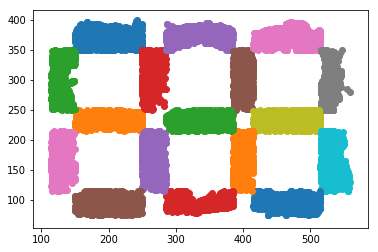

In [451]:
%matplotlib inline
for i in alleyTracking.values():
    plt.scatter(i[:,1],i[:,2])
plt.show()
%matplotlib qt5

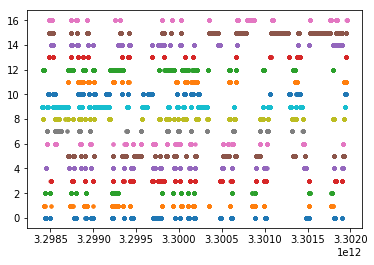

In [452]:
%matplotlib inline
for i,d in alleyTracking.items():
    plt.plot(d[:,0], [i]*d.shape[0],'.')
    

In [5]:
def parseEvents():
    alleyTracking = {i:np.empty((0,3)) for i in range(17)}
    for entry in position:
        for a in alleyBounds.keys():
            if entry[1] > alleyBounds[a][0][0] and entry[1] < alleyBounds[a][0][1] and entry[2] > alleyBounds[a][1][0] and entry[2] < alleyBounds[a][1][1]:
                alleyTracking[a] = np.vstack((alleyTracking[a], entry))
    alleyVisits = {i:[] for i in range(17)} # each list will contain ts corresponding to time of alley visit beginning
    txtVisits = {i:[] for i in range(17)}
    for alley,timestamps in alleyTracking.items():
        vts = getVisits(timestamps[:,0],3*1e6)
        vts = [i for i in vts if len(i)>1]
        vts = [i for i in vts if i[-1]-i[0]>1e6]
        visitTs = [(i[0], i[-1]) for i in vts] # vts returns list of list, each of which is all ts in a group. So first ts is the first ts of a visit, grab it
        alleyVisits[alley] = visitTs
        for visit in visitTs:
            intervalIdx = checkInterval(visit[0]/1e6, alleySwapTS[alley])
            txtVisits[alley].append(stimData['stimuli'][alley][intervalIdx])
    return alleyTracking, alleyVisits, txtVisits


def checkInterval(x, intervals):
    if type(intervals) == list:
        size = len(intervals)-1
    elif type(intervals) == np.ndarray:
        size = intervals.shape[0]-1
    target = None
    for i in range(size):
        if intervals[i] <= x <= intervals[i+1]:
            target = i
    return target

def getNLSwapTimes(rec):
    swapTimes = []
    for i in range(len(rec)-4):
        if rec[i][5] == 1 and rec[i+1][5] == 0:
            swapTimes.append(rec[i][3])
    swapTimes = [i/1e6 for i in swapTimes]
    return swapTimes

def convertPytoNLts(rec, nltimes, pydata):
    '''nl times cleaned first''' 
    pySwapTimes = [i[0] for i in pydata['order'][17:]]
    adjPy = [i - pySwapTimes[0] for i in pySwapTimes]
    projs = [min(enumerate(nltimes), key=lambda x: abs(x[1]-i)) for i in [j+nltimes[0] for j in adjPy]]
    swapTS = [nltimes[i[0]] for i in projs]
    beginTS = [i[3] for i in rec if b'begin session' in i[10]][0]/1e6
    endTS = [i[3] for i in rec if b'end session' in i[10]][0]/1e6
    alleySwapTS = {i:[] for i in range(17)}
    for i in range(len(swapTS)):
        alleySwapTS[pydata['order'][i+17][1]].append(swapTS[i])
    for i in range(17):
        alleySwapTS[i] =  [beginTS] + alleySwapTS[i] + [endTS]
    return alleySwapTS

def getVisits(data, maxgap=3*1e6):
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups

def getVisitPos(alley,visitnum,array):
    '''array is either spike ts or pos ts'''
    tsVisit = getTsinInverval(array, alleyVisits[alley][visitnum][0], alleyVisits[alley][visitnum][1])
    posVisit = getPosFromTs(tsVisit)
    return np.column_stack((tsVisit,posVisit))

def getPosFromTs(yourts):
    '''ts is the full list of ts, yourts are the times you'd like a pos for '''
    adjTs = [util.takeClosest(position[:,0],i) for i in yourts]
    target = np.empty((0,2))
    for i in adjTs:
        target = np.vstack((target,position[np.where(position[:,0]==i)][:,1:][0]))
    return target

def getTsinInverval(array,start,stop):
    '''left inclusive'''
    idx = np.where(np.logical_and(array >= start, array < stop))
    return array[idx[0]]

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before


In [6]:
def getVisitPos(alley,visitnum,array):
    '''array is either spike ts or pos ts'''
    tsVisit = getTsinInverval(array, alleyVisits[alley][visitnum][0], alleyVisits[alley][visitnum][1])
    posVisit = getPosFromTs(tsVisit)
    return np.column_stack((tsVisit,posVisit))

def getVisitsbyTxt(alley,txt,array):
    '''get all alley visits when a given txt was present.
    DO it for spike pos or just pos depending on array you pass'''
    allVisits = np.empty((0,3))
    for i in range(len(alleyVisits[alley])):
        if txtVisits[alley][i] == txt:
            visit = getVisitPos(alley,i,array)
            allVisits = np.vstack((allVisits, visit))
    return allVisits

In [7]:
def alley2dHist(alley,x,y,smooth=0):
    if (alley+1) in [3,17,4,15,6,12,8,10]:
        rbin,cbin = [90,60] #IMPORTANT. Bc np has first dim rows, 2nd dim cols, cartesian x is the cols so 2nd dim so "y" here. 
    else:
        rbin,cbin = [60,90]
#     xbin = np.linspace(alleyBounds[alley][0][0], alleyBounds[alley][0][1], num=rbin)
#     ybin = np.linspace(alleyBounds[alley][1][0], alleyBounds[alley][1][1], num=cbin)
    hist = np.histogram2d(y,x,bins=[rbin,cbin],range=[alleyBounds[alley][1], alleyBounds[alley][0]]) # y,x order is NOT typo
    if smooth != 0:
        hist = gauss(hist[0],smooth)
    return hist

In [8]:
def genLinHist(hist):
    if type(hist) == tuple:
        hist = hist[0] # pull out hist itself if you passed the tuple of (hist,edges)
    if hist.shape[1] > hist.shape[0]:
        ax = 0
    elif hist.shape[1] < hist.shape[0]:
        ax = 1
    linhist = np.mean(hist, axis=ax)
    return linhist

In [29]:
def genLinRateMap(alley,txt):
    '''returns array of lin, occ normed rate maps corresponding to every visit
    of the specified alley with that texture. So avg/sem the *return* array'''
    allrms = np.empty((0,90)) # this is the num bins along long axis of alley. hardcoded here and alley2dhist (short axis has 75bins)
    for i in range(len(alleyVisits[alley])):
        if txtVisits[alley][i] == txt:
            visitsOcc = getVisitPos(alley, i, ts)
            visitsSpk = getVisitPos(alley, i, spikes[:,0])
            occhist = alley2dHist(alley, visitsOcc[:,1], visitsOcc[:,2], 0)
            spkhist = alley2dHist(alley, visitsSpk[:,1], visitsSpk[:,2], 0)
            linocc = genLinHist(occhist)
            linspk = genLinHist(spkhist)
            hs[0,cbins-1] = 0
            h[0,cbins-1] = 0
            rm = (linspk*np.reciprocal(linocc))*33
            rm[np.isnan(rm)] = 0
            rm[np.isinf(rm)] = 0
            rm = gauss(rm,2,mode='nearest',cval=0)
            allrms = np.vstack((allrms, rm))
    return allrms

In [30]:
fig, ax = plt.subplots(6,3,figsize=(10,10))
axList = fig.axes
visits = {i:{'A':None,'B':None,'C':None} for i in range(17)}
for i in range(17):
    for txt,c in zip(['A', 'B', 'C'],['r','b','g']):
        rms = genLinRateMap(i, txt)
        visits[i][txt] = rms
        avg = np.mean(rms, axis=0)
        err = sem(rms, axis=0)
        axList[i].plot(avg,f"{c}--")
        axList[i].fill_between(range(len(err)), avg+err, avg-err,color=f"{c}",alpha=0.5)
        axList[i].set_title(f"Alley {i+1}")

(602,)
(602, 2)
(15,)
(15, 2)


NameError: name 'hs' is not defined

In [527]:
allvisits = {i: np.empty((0,3)) for i in ['A', 'B', 'C']}
allspikes = {i: np.empty((0,3)) for i in ['A', 'B', 'C']} 
_spikes = np.empty((0,3))
_position = np.empty((0,3))
for i in range(17):
    for txt in ['A','B','C']:  
        spk, _pos,_ = alleyRatemapData(i+1,txt)
        _spikes = np.vstack((_spikes, spk))
        _position = np.vstack((_position,_pos))
        allspikes[txt] = np.vstack((allspikes[txt], spk))
        allvisits[txt] = np.vstack((allvisits[txt], _pos))

In [528]:
def data2bins(x,dim):
    '''go from 480/640 scale (data) to 40/60 (bins, change obv if you change bins)'''
    if dim == 'r':
        OldMin,OldMax,NewMin,NewMax = [75, 400, 0, 40]
    elif dim == 'c':
        OldMin,OldMax,NewMin,NewMax = [115, 560, 0, 60]
    NewValue = (((x - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    return NewValue

def drawAlley(ax,oldz):
    z = [[data2bins(oldz[0][0],'c'),data2bins(oldz[0][1],'c')],[data2bins(oldz[1][0],'r'),data2bins(oldz[1][1],'r')]]
    ax.plot([z[0][0], z[0][0]],[z[1][0],z[1][1]],'k',alpha=0.3)
    ax.plot([z[0][1], z[0][1]],[z[1][0],z[1][1]],'k',alpha=0.3)
    ax.plot([z[0][1], z[0][0]],[z[1][1],z[1][1]],'k',alpha=0.3)
    ax.plot([z[0][0], z[0][1]],[z[1][0],z[1][0]],'k',alpha=0.3)
    

In [562]:
rbins = 60
cbins = 90
normed = {'A':None, 'B':None, 'C':None,'O':None}
for txt in ['O','A','B','C']:
    if txt == 'O':
        h = np.histogram2d(_position[:,2], _position[:,1],bins=[rbins,cbins])[0]
        hs = np.histogram2d(_spikes[:,2],_spikes[:,1],bins=[rbins,cbins])[0]
    else:
        h = np.histogram2d(allvisits[txt][:,2], allvisits[txt][:,1],bins=[rbins,cbins])[0]
        hs = np.histogram2d(allspikes[txt][:,2], allspikes[txt][:,1],bins=[rbins,cbins])[0]
    hs[0,cbins-1] = 0
    h[0,cbins-1] = 0
    n = (hs*np.reciprocal(h))*33
    n[np.isnan(n)] = 0
    n[np.isinf(n)] = 0
    normed[txt] = gauss(n,2,mode='nearest',cval=0)
    normed[txt][np.where(h==0)] = np.nan

combined_data = np.array([normed['A'], normed['B'], normed['C'],normed['O']])
h = np.histogram(normed['O'][np.where(normed['O']>0)])
_min, _max = 0.001, h[1][np.where(np.cumsum(h[0])/h[0].sum() > 0.95)[0][0]]
# the ugly little fella above finds the bin edge (units of spike count) which captures more than 95% of the data

fig = plt.figure(figsize=(10,10))
for txt,an in zip(['O','A','B','C'],[1,2,3,4]):
    #Add the vmin and vmax arguments to set the color scale
    ax = fig.add_subplot(4, 1, an)
    im = ax.imshow(normed[txt], vmax = _max, vmin = _min, origin='lower',cmap='YlOrRd')
    #ax.set_adjustable('box-forced')
    if txt == 'O':
        ax.set_title("Overall Ratemap")
    else:
        ax.set_title(f"Collated Texture {txt} Ratemap")
#    for i in alleyBounds.values():
#        drawAlley(ax,i)
    ax.autoscale(False)
                          
cbar_ax = fig.add_axes([0.65, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax,extend='max')
plt.tight_layout(True)
plt.show()

C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  del sys.path[0]
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\whock\Anaconda3\Lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [418]:
%qtconsole --style native

In [62]:
allTxts = []
for i in txtVisits.values():
    allTxts.extend(i)
plt.hist(allTxts)

(array([ 131.,    0.,    0.,    0.,    0.,  104.,    0.,    0.,    0.,  177.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

In [24]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
axList = fig.axes
for i in range(17):
    axList[i].hist(txtVisits[i])
    axList[i].set_title(i)

In [63]:
# get time in s that txt was present on at alley
alleyTxtOnTimes = {i:{'A':0, 'B':0, 'C':0} for i in range(17)}
for alley in range(17):
    for swap in range(len(alleySwapTS[alley])-1):
        alleyTxtOnTimes[alley][stimData['stimuli'][alley][swap]] += alleySwapTS[alley][swap+1] - alleySwapTS[alley][swap]

In [64]:
normedTxtVisits = {i:{'A':0, 'B':0, 'C':0} for i in range(17)}
for i in range(17):
    for txt in ['A', 'B', 'C']:
        normedTxtVisits[i][txt] = txtVisits[i].count(txt) / alleyTxtOnTimes[alley][txt]

In [65]:
%matplotlib qt5
fig, ax = plt.subplots(5,5,figsize=(10,10))
axList = fig.axes
for i in range(17):
    axList[i].bar([1,2,3],list(normedTxtVisits[i].values()))
    axList[i].set_title(i)

In [66]:
allTxtsNormed = {'A':[], 'B':[], 'C':[]}
for i in range(17):
    for txt in ['A', 'B', 'C']:
        allTxtsNormed[txt].append(normedTxtVisits[i][txt])
for txt in ['A', 'B', 'C']:
    print(np.mean(allTxtsNormed[txt]))

0.0226130316053
0.00857271215255
0.00412098351487


In [55]:
days = [str(i+1) for i in range(2,10)]
for d in ['2','3','4','5','8','9','11']:
    os.chdir(f"D:\\Ratterdam\\R765\\R765DFD{d}")
    print(os.getcwd())
    for f in os.listdir():
        if "Stimuli" in f:
            stimData = pickle.load(open(datafile+"R765_180629_18-48_Stimuli.p","rb"))
    pos = util.read_pos(os.getcwd()+"\\")
    ts = np.asarray(sorted(list(pos.keys())))
    posx = [640 - pos[i][0] for i in ts]
    posy = [pos[i][1] for i in ts]
    for t in ts:
        pos[t][0] = 640 - pos[t][0]
    position = np.column_stack((ts,posx,posy))
    hdr, rec = util.readNEV(os.getcwd()+"\\")
    swapTimes = getNLSwapTimes(rec)
    alleySwapTS = convertPytoNLts(rec, swapTimes, stimData)
    alleyTracking, alleyVisits,  txtVisits = parseEvents()
    
    allTxts = []
    for i in txtVisits.values():
        allTxts.extend(i)
        
    alleyTxtOnTimes = {i:{'A':0, 'B':0, 'C':0} for i in range(17)}
    for alley in range(17):
        for swap in range(len(alleySwapTS[alley])-1):
            alleyTxtOnTimes[alley][stimData['stimuli'][alley][swap]] += alleySwapTS[alley][swap+1] - alleySwapTS[alley][swap]
            
    normedTxtVisits = {i:{'A':0, 'B':0, 'C':0} for i in range(17)}
    for i in range(17):
        for txt in ['A', 'B', 'C']:
            normedTxtVisits[i][txt] = txtVisits[i].count(txt) / alleyTxtOnTimes[alley][txt]
            
    allTxtsNormed = {'A':[], 'B':[], 'C':[]}
    for i in range(17):
        for txt in ['A', 'B', 'C']:
            allTxtsNormed[txt].append(normedTxtVisits[i][txt])
    print("---------------")
    print(os.getcwd())
    for txt in ['A', 'B', 'C']:
        print(np.mean(allTxtsNormed[txt]))

            

D:\Ratterdam\R765\R765DFD2
---------------
D:\Ratterdam\R765\R765DFD2
0.00845321738921
0.00865216229537
0.00288864212685
D:\Ratterdam\R765\R765DFD3
---------------
D:\Ratterdam\R765\R765DFD3
0.00351630458756
0.00880571855943
0.00843878951033
D:\Ratterdam\R765\R765DFD4
---------------
D:\Ratterdam\R765\R765DFD4
0.0226130316053
0.00857271215255
0.00412098351487
D:\Ratterdam\R765\R765DFD5
---------------
D:\Ratterdam\R765\R765DFD5
0.0256627904759
0.0094596844059
0.00514385784036
D:\Ratterdam\R765\R765DFD8
---------------
D:\Ratterdam\R765\R765DFD8
0.0173747989835
0.0107278595961
0.00376371139616
D:\Ratterdam\R765\R765DFD9
---------------
D:\Ratterdam\R765\R765DFD9
0.01631284328
0.0116743602304
0.00516298715473
D:\Ratterdam\R765\R765DFD11
---------------
D:\Ratterdam\R765\R765DFD11
0.0173297824305
0.023056910857
0.0054012657391


## Ground truth choice behavior

In [414]:
for i, alleyData in enumerate(alleyVisits.values()):
    for data in alleyData:
        plt.plot([data[0], data[1]], [i, i])

In [415]:
visitList = []
for i, alleyData in enumerate(alleyVisits.values()):
    for data in alleyData:
        visitList.append([i,data[1]])
        visitList = sorted(visitList, key = lambda x: x[1])
for i in range(len(visitList)):
    visitList[i][0] += 1

In [416]:
alleyGraph = {1:[[4,5],[3]],
              2:[[4, 13, 15],[3, 17]],
              3:[[1],[2, 17]],
              4:[[1, 5],[2, 13, 15]],
              5:[[1,4],[6,7]],
              6:[[5,7],[13,12,9]],
              7:[[5,6], [8]],
              8:[[7], [9,10]],
              9:[[8,10], [6,13,12]],
              10:[[8,9], [11]],
              11:[[10],[12,14]],
              12:[[6,13,9],[14,11]],
              13:[[6,9,12],[2,4,15]],
              14:[[12,11],[15,16]],
              15:[[2,4,13],[16,14]],
              16:[[14,15], [17]],
              17:[[2,3],[16]]}

In [417]:
scores = []
def scoreFx(pick,availble):
    pass

def findTxt(ts,alley):
    '''what txt was present at a given '''
    return stimData['stimuli'][alley-1][bisect(alleySwapTS[alley-1],ts/1e6)-1] # bisect finds where to put this ts in list of txt swaps
                                                                       # then look up the previous entry in txt list, i.e. one present during that ts
            

def getAvailTxts(ts, alleys):
    '''get the textures present at the alleys at the ts'''
    txtsAvailable = []
    for alley in alleys:
        txt = findTxt(ts,alley)
        txtsAvailable.append(txt)
    return txtsAvailable
        
availableTxts = []
choices = []
for i,visit in enumerate(visitList):
    side = None
    if i < len(visitList)-1:
        choice = visitList[i+1][0]
        if choice in alleyGraph[visit[0]][0]:
            side = alleyGraph[visit[0]][0]
        elif choice in alleyGraph[visit[0]][1]:
            side = alleyGraph[visit[0]][1]
        else:
            pass
        if side:
            availableTxts.append(getAvailTxts(visit[1], side))
            choices.append(findTxt(visit[1],choice))
            
        
        

In [418]:
valueLookup = {'A':.8, 'B':.4, 'C':.1}
def calcNullChoiceVal(options):
#     vals = []
#     for txt in ['A', 'B', 'C']:
#         vals.append((options.count(txt)/len(options))*valueLookup[txt])
#     v = sum(vals)
    vals = []
    for i in range(100):
        vals.append(valueLookup[random.choice(options)])
    v = np.mean(vals)
        
    return v

In [419]:
def calcRealChoiceVal(choice, options, null):
#     if sorted(options).index(choice) == 0:
#         return 1
#     else:
#         return 0
    return valueLookup[choice] - null
    

In [420]:
# Metric is to compute a null value for the options available defined as (prop of arms w a txt)*(val of txt) for all txts. Then
# subtract this off the real chosen val for an adjusted choice val. Then you can plot it, etc but the primary stat is the avg +/- sem compared to a 
# null hypothesis of 0 avg
realVals = []
for choice, options in zip(choices, availableTxts):
    nullVal = calcNullChoiceVal(options)
    realVals.append(valueLookup[choice] - nullVal)
    
    

In [423]:
days = [str(i+1) for i in range(2,10)]
for d in ['4']:
    os.chdir(f"D:\\Ratterdam\\R765\\R765DFD{d}")
    print(os.getcwd())
    for f in os.listdir():
        if "Stimuli" in f:
            stimData = pickle.load(open(f,"rb"))
    pos = util.read_pos(os.getcwd()+"\\")
    ts = np.asarray(sorted(list(pos.keys())))
    posx = [640 - pos[i][0] for i in ts]
    posy = [pos[i][1] for i in ts]
    for t in ts:
        pos[t][0] = 640 - pos[t][0]
    position = np.column_stack((ts,posx,posy))
    hdr, rec = util.readNEV(os.getcwd()+"\\")
    swapTimes = getNLSwapTimes(rec)
    alleySwapTS = convertPytoNLts(rec, swapTimes, stimData)
    alleyTracking, alleyVisits,  txtVisits = parseEvents()
    
    visitList = []
    for i, alleyData in enumerate(alleyVisits.values()):
        for data in alleyData:
            visitList.append([i,data[1]])
            visitList = sorted(visitList, key = lambda x: x[1])
    for i in range(len(visitList)):
        visitList[i][0] += 1
            
    availableTxts = []
    
    choices = []
    for i,visit in enumerate(visitList):
        side = None
        if i < len(visitList)-1:
            choice = visitList[i+1][0]
            if choice in alleyGraph[visit[0]][0]:
                side = alleyGraph[visit[0]][0]
            elif choice in alleyGraph[visit[0]][1]:
                side = alleyGraph[visit[0]][1]
            else:
                pass
            if side:
                availableTxts.append(getAvailTxts(visit[1], side))
                choices.append(findTxt(visit[1],choice))
    realVals = []
    for choice, options in zip(choices, availableTxts):
        nullVal = calcNullChoiceVal(options)
        realVals.append(calcRealChoiceVal(choice, options, nullVal))
        
    print("-----------")
    print(os.getcwd())
    print(f"Mean: {np.mean(realVals)} with err {sem(realVals)}")

D:\Ratterdam\R765\R765DFD4
-----------
D:\Ratterdam\R765\R765DFD4
Mean: 0.017680440771349924 with err 0.010617096073391405


## Reconciling rate maps
### Common process w. 5 outputs 1) 2d track rm 2) 2d track rm by txt 3) avg lin rm 4) all visits lin rm 5) alley 2d rm

In [10]:
def alleyRatemapData(alley,txt):
    '''basic unit of analysis. get all visits by a txt
    Return array of spikes and pos for that txt/alley combo '''
    alley = alley-1
    alleyPos = np.empty((0,3))
    alleySpikes = np.empty((0,3))
    visitidx = np.empty((0,2))
    for i in range(len(alleyVisits[alley])):
        if txtVisits[alley][i] == txt:
            visitsOcc = getVisitPos(alley, i, ts)
            visitsSpk = getVisitPos(alley, i, spikes[:,0])
            alleyPos = np.vstack((alleyPos, visitsOcc))
            alleySpikes = np.vstack((alleySpikes, visitsSpk))
            visitidx = np.vstack((visitidx, (visitsSpk.shape[0],visitsOcc.shape[0])))
    spkI = np.cumsum(visitidx[:,0]).astype(int)-1
    posI = np.cumsum(visitidx[:,1]).astype(int)-1
    return alleySpikes, alleyPos, np.column_stack((spkI,posI))

In [41]:
plt.figure(3)
cutoff = 20
rbins, cbins = 45,90
hs = np.histogram2d(spikes[:,2],spikes[:,1],bins=[rbins,cbins])[0]
ho = np.histogram2d(position[:,2],position[:,1],bins=[rbins,cbins])[0]
hs[0,cbins-1] = 0
ho[0,cbins-1] = 0
n = (hs*np.reciprocal(ho))*33
n[np.isnan(n)] = 0
n[np.isinf(n)] = 0
n = gauss(n,2,mode='nearest',cval=0)
n[np.where(ho==0)] = np.nan
_min,_max = 0.0001, np.median(n[np.where(n>0)])*cutoff
plt.imshow(n, origin='lower',vmin=_min,vmax=_max)
plt.colorbar()

C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [403]:
plt.figure(3)
plt.imshow(hs,origin='lower')
plt.figure(4)
plt.imshow(ho,origin='lower')

In [11]:
rbinNum,cbinNum = 16,31
alleyBins = {i:{'rows':None,'cols':None} for i in range(17)}
for i,v in enumerate(alleyBounds.values()):
    x,y = v
    if (x[1]-x[0]) > (y[1]-y[0]):
        bins = [rbinNum,cbinNum]
    elif (y[1]-y[0]) > (x[1]-x[0]):
        bins = [cbinNum,rbinNum]
    else:
        print("error")
    alleyBins[i]['rows'] = np.linspace(alleyBounds[i][1][0], alleyBounds[i][1][1],num=bins[0])
    alleyBins[i]['cols'] = np.linspace(alleyBounds[i][0][0], alleyBounds[i][0][1],num=bins[1])

In [103]:
_spikes,_position = allTrack['spk'],allTrack['pos']
fig = plt.figure(figsize=(10,10))
r = 6
c = 3
cutoff = 20
_min, _max = 0,0 #adjust the max 0 to whatever the consensus max is
alleyRMs = {i:None for i in range(17)}
for i in range(17):
    rbins,cbins = alleyBins[i]['rows'], alleyBins[i]['cols']
    if rbins.shape[0] > cbins.shape[0]:
        hs = np.histogram2d(_spikes[:,1],_spikes[:,2],bins=[alleyBins[i]['cols'],alleyBins[i]['rows']])[0]
        ho = np.histogram2d(_position[:,1],_position[:,2],bins=[alleyBins[i]['cols'],alleyBins[i]['rows']])[0]
    else:
        hs = np.histogram2d(_spikes[:,2],_spikes[:,1],bins=[alleyBins[i]['rows'],alleyBins[i]['cols']])[0]
        ho = np.histogram2d(_position[:,2],_position[:,1],bins=[alleyBins[i]['rows'],alleyBins[i]['cols']])[0]
    hs[0,cbins.shape[0]-2] = 0
    ho[0,cbins.shape[0]-2] = 0
    n = (hs*np.reciprocal(ho))*33
    n[np.isnan(n)] = False
    n[np.isinf(n)] = False
    n = gauss(n,2,mode='nearest',cval=0)
    n[np.where(ho==0)] = np.nan
    alleyRMs[i] = n
concat = np.empty((rbinNum-1,cbinNum-1))
for i in range(17):
    concat = np.vstack((concat,alleyRMs[i]))
_max = np.median(concat[np.where(concat>0)])*cutoff
for i in range(1,18):
    ax = fig.add_subplot(r,c,i)
    im = ax.imshow(alleyRMs[i-1], vmin=_min, vmax=_max, origin='lower')
    ax.set_title(f"Alley {i}")
    
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax,extend='max')

C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [371]:
a=1
aspk, apos,_ = alleyRatemapData(a,'A')
bspk, bpos,_ = alleyRatemapData(a,'B')
cspk, cpos,_ = alleyRatemapData(a,'C')
_spikes = np.vstack((aspk, bspk, cspk))
_position = np.vstack((apos, bpos, cpos))
cutoff = 5
#_spikes,_position = alleyRatemapData(a,t)
rbins,cbins = alleyBins[a-1]['rows'], alleyBins[a-1]['cols']
if rbins.shape[0] > cbins.shape[0]:
    hs = np.histogram2d(_spikes[:,1],_spikes[:,2],bins=[alleyBins[a-1]['cols'],alleyBins[a-1]['rows']])[0]
    ho = np.histogram2d(_position[:,1],_position[:,2],bins=[alleyBins[a-1]['cols'],alleyBins[a-1]['rows']])[0]
else:
    hs = np.histogram2d(_spikes[:,2],_spikes[:,1],bins=[alleyBins[a-1]['rows'],alleyBins[a-1]['cols']])[0]
    ho = np.histogram2d(_position[:,2],_position[:,1],bins=[alleyBins[a-1]['rows'],alleyBins[a-1]['cols']])[0]
n = (hs*np.reciprocal(ho))*33
n[np.isnan(n)] = False
n[np.isinf(n)] = False
n = gauss(n,2,mode='nearest')
n[np.where(ho==0)] = np.nan
_min, _max = 0.000001, np.median(n[np.where(n>0)])*cutoff
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(n, vmin=_min, vmax=_max, origin='lower')
ax.set_title(f"Alley {a}")
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax,extend='max')


C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  app.launch_new_instance()
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


In [12]:
def alleyData(alley,array):
    '''get all spikes/pos in an alley'''
    alley = alley-1
    z = array[
        (array[:,1] > alleyBounds[alley][0][0]) & \
        (array[:,1] < alleyBounds[alley][0][1]) & \
        (array[:,2] > alleyBounds[alley][1][0]) & \
        (array[:,2] < alleyBounds[alley][1][1])  
                       ]
    return z

def findTxt(ts,alley):
    '''what txt was present at a given '''
    return stimData['stimuli'][alley-1][bisect(alleySwapTS[alley-1],ts/1e6)-1] # bisect finds where to put this ts in list of txt swaps
                                                                       # then look up the previous entry in txt list, i.e. one present during that ts
        

In [386]:
z = alleyData(11,spikes)
tz = [findTxt(i,11) for i in z[:,0]]

In [13]:
vts = getVisits(p[:,0],0.1*1e6)
vts = [i for i in vts if len(i)>1]
vts = [i for i in vts if i[-1]-i[0]>0.1e6]

NameError: name 'p' is not defined

In [14]:
allTrackbyTxt = {'A':{'spk':np.empty((0,3)),'pos':np.empty((0,3))},
                 'B':{'spk':np.empty((0,3)),'pos':np.empty((0,3))},
                 'C':{'spk':np.empty((0,3)),'pos':np.empty((0,3))}}

allTrack = {'spk':np.empty((0,3)),'pos':np.empty((0,3))}
alleyByTxt = {i:{'A':{'spk':None,'pos':None,'idx':None},
                 'B':{'spk':None,'pos':None,'idx':None},
                 'C':{'spk':None,'pos':None,'idx':None}}
                for i in range(1,18)}

for i in range(1,18):
    for txt in ['A','B','C']:
        s, p, x = alleyRatemapData(i,txt)
        
        for entry,data in zip(['spk','pos','idx'],[s,p,x]):
            alleyByTxt[i][txt][entry] = data
    
        for entry, data in zip(['spk','pos'],[s,p]):
            allTrackbyTxt[txt][entry] = np.vstack((allTrackbyTxt[txt][entry],data))
            allTrack[entry] = np.vstack((allTrack[entry], data))

In [85]:
def makeWholeTrack2dHist(sarr,parr,bins,label='',cutoff=1,myMax=None,retRM=False):
    '''for whole track, bins will be [int, int].
    For alley hist (sep fx), bins will be [arr arr]'''
    rbins, cbins = bins[0],bins[1]
    hs = np.histogram2d(sarr[:,2],sarr[:,1],bins=[rbins,cbins])[0]
    ho = np.histogram2d(parr[:,2],parr[:,1],bins=[rbins,cbins])[0]
    hs[0,cbins-1] = 0
    ho[0,cbins-1] = 0
    n = (hs*np.reciprocal(ho))*33
    n[np.isnan(n)] = False
    n[np.isinf(n)] = False
    n = gauss(n,2,mode='nearest')
    n[np.where(ho==0)] = np.nan
    if myMax == None:
        _min, _max = 0.000001, np.max(n[np.where(n>0.01)])*0.75
    else:
        _min, _max = 0.000001, myMax
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(n, vmin=_min, vmax=_max, origin='lower')
    ax.set_title(f"Track {label}")
    cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax,extend='max')
    if label == 'All Textures' and retRM:
            return _max, n
    elif label == 'All Textures' and not retRM:
            return _max
    else:
        return None

In [16]:
def linHist(alley,spikes,position,nanpol):
    '''1-indexed alley. Using [arr, arr] for bins from alleyBins'''
    rbins,cbins = alleyBins[alley-1]['rows'], alleyBins[alley-1]['cols']
    if rbins.shape[0] < cbins.shape[0]:
        hs = np.histogram2d(spikes[:,1],spikes[:,2],bins=[cbins,rbins])[0]
        ho = np.histogram2d(position[:,1],position[:,2],bins=[cbins,rbins])[0]
        ls,lo  = np.sum(hs,axis=1), np.sum(ho,axis=1)
    else:
        hs = np.histogram2d(spikes[:,2],spikes[:,1],bins=[rbins,cbins])[0]
        ho = np.histogram2d(position[:,2],position[:,1],bins=[rbins,cbins])[0]
        ls,lo  = np.sum(hs,axis=1), np.sum(ho,axis=1)
    n = (ls*np.reciprocal(lo))*33
    n[np.isnan(n)] = 0
    n[np.isinf(n)] = 0
    n = gauss(n,1,mode='nearest')
    if nanpol == 'nan':
        n[np.where(lo==0)] = np.nan
    elif nanpol == 'zero':
        n[np.where(lo==0)] = 0
    return n

    

In [17]:
def getVisits(alley,txt):
    spikes, pos, idx = alleyByTxt[alley][txt]['spk'],alleyByTxt[alley][txt]['pos'],alleyByTxt[alley][txt]['idx']
    sv, pv = np.split(spikes,idx[:,0]), np.split(pos,idx[:,1]) # list of subarrays
    sv,pv
    return sv,pv

In [18]:
def linearizeAlley(alley,txt,**kwargs):
    '''Given spike/pos arrays corresponding to all data in alley
    and array of indices separating different visits, linearize occ norm
    visit and return all visits (opts='both') or just visits/mean (opt='visits'/'mean')
    1st col of idx is spk visit indx, 2nd is pos visit idx
    '''
    rms = getVisits(alley, txt)
    spikes, pos, idx = alleyByTxt[alley][txt]['spk'],alleyByTxt[alley][txt]['pos'],alleyByTxt[alley][txt]['idx']
    sv, pv = np.split(spikes,idx[:,0]), np.split(pos,idx[:,1]) # list of subarrays
    rms = np.empty((0,cbinNum-1))
    for _s, _p in zip(sv,pv):
        lv = linHist(alley,_s,_p,nanpol=kwargs['nanpol'])
        rms = np.vstack((rms, lv))
    return rms
    
    
    
    

In [19]:
from matplotlib.colors import LinearSegmentedColormap
def makeCustomColormap(nb=100,name='mymap',c=[]):
    if c ==[]:
        c = [(0,0,1),(1,1,0),(1,0,0)]
    mycm = LinearSegmentedColormap.from_list(cmap_name,c,N=nb)
    return mycm

In [23]:
fig, ax = plt.subplots(6,3,figsize=(10,10))
axList = fig.axes
visits = {i:{'A':None,'B':None,'C':None} for i in range(17)}
for alley in range(17):
    for txt,c in zip(['A', 'B', 'C'],['r','b','g']):
        rms = linearizeAlley(alley+1, txt,**{'nanpol':'zero'})
        visits[alley][txt] = rms
        avg = np.mean(rms, axis=0)
        err = sem(rms, axis=0)
        axList[alley].plot(avg,f"{c}--")
        axList[alley].fill_between(range(len(err)), avg+err, avg-err,color=f"{c}",alpha=0.5)
        axList[alley].set_title(f"Alley {alley+1}")

C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in reciprocal
  if sys.path[0] == '':
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
C:\Users\whock\Anaconda3\Lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\whock\Anaconda3\Lib\site-packages\numpy\core\_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [24]:
def viewVisits(alley,txt, viewType):
    '''options are "imshow" or "linear"'''
    if viewType == 'imshow':
        rms = linearizeAlley(alley,txt,**{'nanpol':'nan'})
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(rms, cmap=mycm)
        ax.set_title(f"Alley {alley}, Texture {txt}")
        cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax,extend='max')
    elif viewType == 'linear':
        rms = linearizeAlley(alley, txt, **{'nanpol':'zero'})
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title(f"Alley {alley}, Texture {txt}")
        for i in rms:
            plt.plot(i)
        


In [96]:
for subdir, dirs, fs in os.walk(datafile):
    for f in fs:
        if 'cl-maze' in f and 'OLD' not in f and 'Undefined' not in f:
            clustname = subdir[subdir.index("TT"):] + "_" + f
            print(clustname)
            clust = util.read_clust(datafile+clustname.split("_")[0]+"\\"+clustname.split("_")[1])
            clust = np.asarray(clust)
            ts = np.asarray(sorted(list(pos.keys())))
            posx = [640 - pos[i][0] for i in ts]
            posy = [pos[i][1] for i in ts]
            for t in ts:
                pos[t][0] = 640 - pos[t][0]
            position = np.column_stack((ts,posx,posy))
            spikexy = getPosFromTs(clust)
            spikes = np.column_stack((clust,spikexy))
            spikes = spikes[np.where(spikes[:,2] > 50)]
            position = position[np.where(position[:,2] > 50)]
            
            allTrackbyTxt = {'A':{'spk':np.empty((0,3)),'pos':np.empty((0,3))},
                 'B':{'spk':np.empty((0,3)),'pos':np.empty((0,3))},
                 'C':{'spk':np.empty((0,3)),'pos':np.empty((0,3))}}

            allTrack = {'spk':np.empty((0,3)),'pos':np.empty((0,3))}
            alleyByTxt = {i:{'A':{'spk':None,'pos':None,'idx':None},
                             'B':{'spk':None,'pos':None,'idx':None},
                             'C':{'spk':None,'pos':None,'idx':None}}
                            for i in range(1,18)}

            for i in range(1,18):
                for txt in ['A','B','C']:
                    s, p, x = alleyRatemapData(i,txt)

                    for entry,data in zip(['spk','pos','idx'],[s,p,x]):
                        alleyByTxt[i][txt][entry] = data

                    for entry, data in zip(['spk','pos'],[s,p]):
                        allTrackbyTxt[txt][entry] = np.vstack((allTrackbyTxt[txt][entry],data))
                        allTrack[entry] = np.vstack((allTrack[entry], data))

            with PdfPages(savepath+dayname+clustname+".pdf") as pdf:
                allMax = makeWholeTrack2dHist(allTrack['spk'],allTrack['pos'],[40,60],label='All Textures',cutoff=15,myMax=None,retRM=False)
                pdf.savefig()
                plt.close()
                print("Completed whole track RM")
                for txt in ['A','B','C']:
                    _ = makeWholeTrack2dHist(allTrackbyTxt[txt]['spk'],allTrackbyTxt[txt]['pos'],[40,60],label=txt,cutoff=15,myMax=allMax,retRM=False)
                    pdf.savefig()
                    plt.close()
                    print(f"Completed {txt} RM")
                    
                fig, ax = plt.subplots(6,3,figsize=(10,10))
                axList = fig.axes
                visits = {i:{'A':None,'B':None,'C':None} for i in range(17)}
                for alley in range(17):
                    for txt,c in zip(['A', 'B', 'C'],['r','b','g']):
                        rms = linearizeAlley(alley+1, txt,**{'nanpol':'zero'})
                        visits[alley][txt] = rms
                        avg = np.mean(rms, axis=0)
                        err = sem(rms, axis=0)
                        axList[alley].plot(avg,f"{c}--")
                        axList[alley].fill_between(range(len(err)), avg+err, avg-err,color=f"{c}",alpha=0.5)
                        axList[alley].set_title(f"Alley {alley+1}")
                pdf.savefig()
                plt.close()
                print("Completed Lin Hists")

TT14_cl-maze1.1


C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in reciprocal
  if __name__ == '__main__':
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


Completed whole track RM
Completed A RM
Completed B RM
Completed C RM


C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in reciprocal
  if sys.path[0] == '':
C:\Users\whock\Anaconda3\Lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
C:\Users\whock\Anaconda3\Lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\whock\Anaconda3\Lib\site-packages\numpy\core\_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Completed Lin Hists
TT14_cl-maze1.2
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT14_cl-maze1.3
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT14_cl-maze1.4
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT14_cl-maze1.5
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT14_cl-maze1.6
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT4_cl-maze1.1
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT4_cl-maze1.10
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT4_cl-maze1.2
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT4_cl-maze1.3
Completed whole track RM
Completed A RM
Completed B RM
Completed C RM
Completed Lin Hists
TT4_cl-maze1.4
Completed whol

### Simulating ways of linearizing 

In [ ]:
medians = []
avgs = []
lins = []
for i in range(1000):
    nums = [np.random.randint(0,20) for i in range(100)]
    denoms = [np.random.randint(3,80) for i in range(100)]
    ratios = [a/b for a,b in zip(nums,denoms)]
    avgs.append(np.mean(ratios))
    lins.append(np.sum(nums)/np.sum(denoms))
    medians.append(np.median(ratios))

In [ ]:
for data,color,l in zip([avgs,lins,medians],['r','b','g'],["Average","'Linearized'","Medians"]):
    plt.plot(data,f"{color}",label=l)
    plt.legend(["Average","'Linearized'","Medians"],fontsize=20)

In [ ]:
diffLinAvg = [(a-b)/a for a,b in zip(lins,avgs)]
diffLinMed = [(a-b)/a for a,b in zip(lins,medians)]